# 03 – Momentum Signal Generation and Portfolio Construction

This notebook builds the **cross-sectional momentum signal (12–1 model)** and constructs portfolios based on relative strength.  
We identify monthly *winners* and *losers* using the cumulative performance of the past 12 months (excluding the most recent one) and generate both **long-only** and **long-short** portfolios for backtesting.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

## 1. Parameter Configuration
We define the key parameters of the momentum strategy:

| Parameter | Description | Typical Value |
|------------|-------------|----------------|
| **lookback (L)** | Number of months used to measure past performance | 12 |
| **skip (S)** | Months skipped before ranking (to avoid short-term reversal) | 1 |
| **holding (H)** | Holding period in months for each cohort | 3 |
| **quantile (Q)** | Top and bottom percentage of assets classified as winners and losers | 20% |

This configuration corresponds to the classic **“12–1 momentum”** setup from Jegadeesh & Titman (1993).

In [3]:
loopback = 12     #months used to measure momentum
skip = 1          #excluding last month
holding = 3       #holding period
quantile = 0.2    #top/bottom 20%

In [4]:
monthly_returns = pd.read_csv("data/processed/sp500_20_returns.csv", index_col=0, parse_dates=True)

## 2. Compute Cross-Sectional Momentum Signal
The momentum signal for each asset is defined as the cumulative return over the past 12 months, excluding the most recent month:

$$
\text{momentum}_{i,t} \;=\; \prod_{k=2}^{12} \bigl(1 + r_{i,t-k}\bigr) \;-\; 1
$$

This represents medium-term performance while avoiding mean-reversion effects in the most recent month.

In [5]:
rolling_prod = (1 + monthly_returns).rolling(window=loopback).apply(np.prod, raw=True)
momentum_signal = rolling_prod / (1 + monthly_returns.shift(1)) - 1
momentum_signal = momentum_signal.dropna()

## 3. Visualize Momentum Intensity Over Time
The heatmap below shows how the momentum signal evolves for each asset over time. Green shades represent strong positive momentum (recent outperformance), while orange indicates negative momentum. This helps identify persistent trends and cyclical patterns.

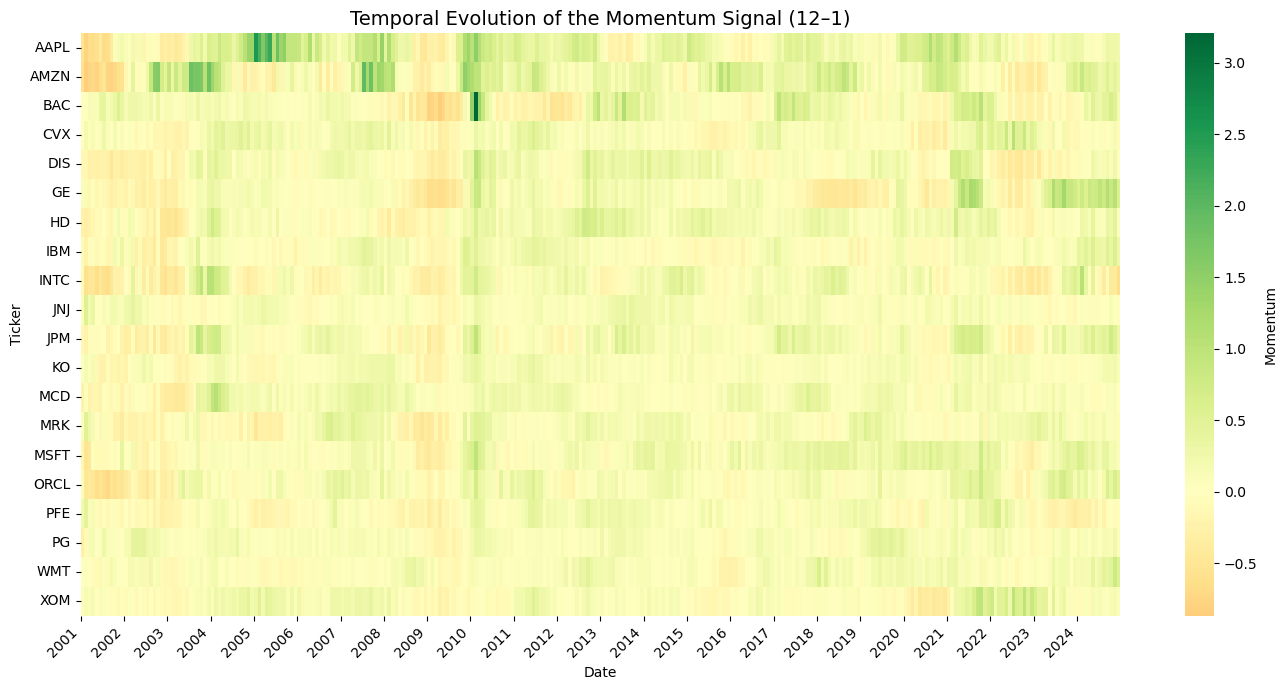

In [6]:
plt.figure(figsize=(14, 7))
ax = sns.heatmap(momentum_signal.T, cmap="RdYlGn", center=0, cbar_kws={"label": "Momentum"})

plt.title("Temporal Evolution of the Momentum Signal (12–1)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Ticker")

n = len(momentum_signal.index)
step = 12  # one label every 12 months (≈ yearly)
tick_positions = range(0, n, step)
tick_labels = momentum_signal.index[tick_positions].strftime("%Y")

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Green → positive momentum (strength)
# Red → negative momentum (weakness)

## 4. Rank Assets and Identify Winners / Losers
Each month, all assets are ranked by their momentum signal.  
- **Top 20% (Winners):** assets with strongest recent performance  
- **Bottom 20% (Losers):** assets with weakest recent performance  

This cross-sectional ranking forms the basis for the long and short portfolio construction.

In [7]:
ranks = momentum_signal.rank(axis=1, ascending=False, method='first')
n_assets = momentum_signal.shape[1]
cut = int(n_assets * quantile)

winners_mask = (ranks <= cut).astype(int)
losers_mask = (ranks >= n_assets - cut + 1).astype(int)

## 5. Generate Portfolio Weights
We assign **equal weights** within each group:
- **Long-Only Portfolio:** equally weighted among winners only  
- **Long-Short Portfolio:** equally weighted long winners and short losers (market-neutral)  

Weights are normalized each month so that the portfolio remains balanced.

In [8]:
Nw = winners_mask.sum(axis=1)
Nl = losers_mask.sum(axis=1)

weights_long_only = winners_mask.div(Nw, axis=0)
weights_long_short = winners_mask.div(Nw, axis=0) - losers_mask.div(Nl, axis=0)

## 6. Apply Holding Period (H = 3 Months)
To simulate overlapping cohorts, each monthly portfolio is held for 3 months.  
The effective weights at time *t* are the average of the last three active portfolios:

$$
w_t \;=\; \frac{1}{H}\sum_{h=0}^{H-1} w_{t-h}
$$

This smooths returns and better reflects realistic portfolio management.

In [9]:
# Apply a 3-month fixed holding (overlapping portfolios)
weights_holding = sum([weights_long_short.shift(i) for i in range(holding)]) / holding
weights_holding = weights_holding.dropna()

## 7. Frequency of Selection
The bar chart below shows how often each stock appeared as a *winner* or *loser* during the sample period,  
along with the net difference (Winners – Losers).  
This reveals which assets tend to display consistent momentum strength.

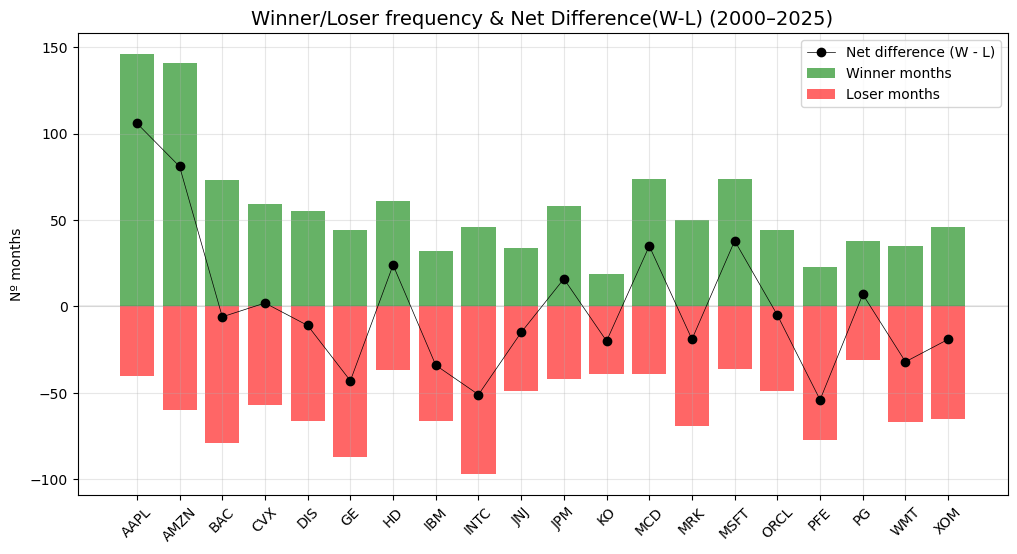

In [10]:
winners_freq = winners_mask.sum(axis=0)
losers_freq = losers_mask.sum(axis=0)

diff_freq = winners_freq - losers_freq

plt.figure(figsize=(12,6))

plt.bar(winners_freq.index, winners_freq, color="green", alpha=0.6, label="Winner months")
plt.bar(losers_freq.index, -losers_freq, color="red", alpha=0.6, label="Loser months")

plt.plot(diff_freq.index, diff_freq, color="black", linewidth=0.5, marker="o", label="Net difference (W - L)")

plt.axhline(0, color="black", linewidth=0.1)
plt.xticks(rotation=45)
plt.title("Winner/Loser frequency & Net Difference(W-L) (2000–2025)", fontsize=14)
plt.ylabel("Nº months")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 8. Net Portfolio Exposure
The plot below shows the evolution of total portfolio exposure over time.  
A flat line near zero indicates the long-short portfolio is properly market-neutral,  
while the long-only version maintains positive net exposure by construction.

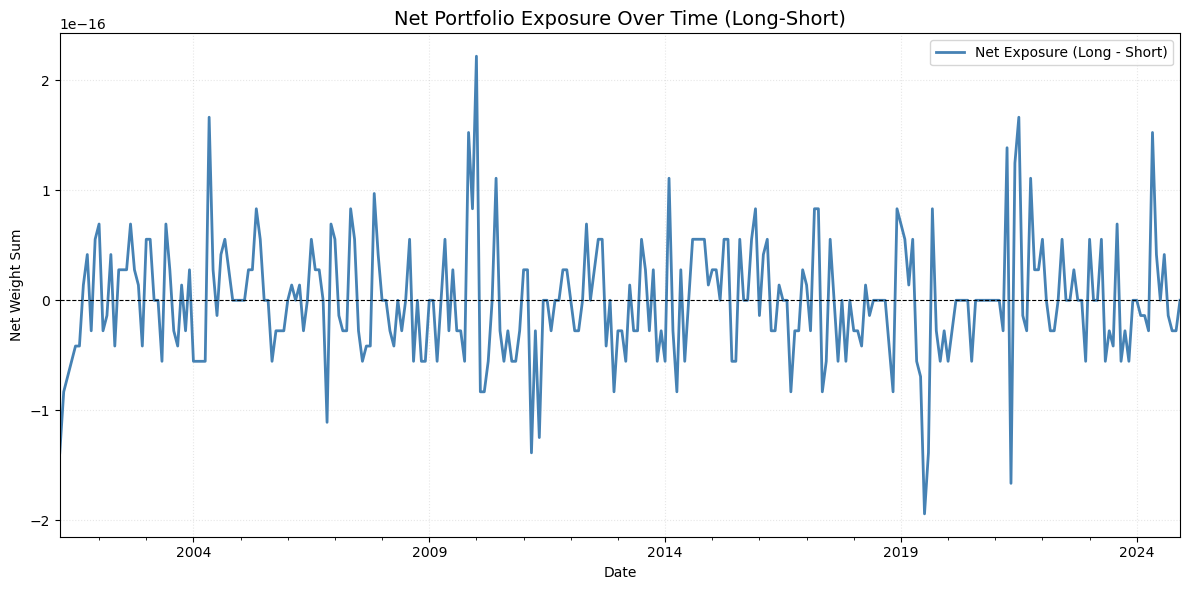

In [11]:
plt.figure(figsize=(12, 6))
weights_holding.sum(axis=1).plot(color='steelblue', lw=2, label='Net Exposure (Long - Short)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Net Portfolio Exposure Over Time (Long-Short)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Net Weight Sum")
plt.grid(alpha=0.3, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
momentum_signal.to_csv("data/processed/momentum_signal_static.csv")
weights_long_only.to_csv("data/processed/weights_long_only_static.csv")
weights_long_short.to_csv("data/processed/weights_long_short_static.csv")
weights_holding.to_csv("data/processed/weights_holding_static.csv")

### Summary
- Constructed the **12–1 cross-sectional momentum signal** using monthly returns.  
- Ranked assets each month to form winner and loser portfolios.  
- Implemented equal-weighted **long-only** and **long-short** portfolios with a 3-month holding period.  
- Generated key visualizations (signal heatmap, selection frequency, exposure) for interpretation.  

The resulting weights and signals are now ready for **backtesting and performance evaluation** in the next notebook.